In [1]:
import geopandas
import shapely
import numpy
from IPython.core.display import display, HTML

display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
aligned = geopandas.read_file(r"C:\Users\pearsonra\Documents\data\river_bathemetry\waikanae_new_lidar\caches\100000000\aligned_channel_100000000.geojson")

## Extended line offshore from the aligned line

In [18]:
(x,y) = aligned.loc[0].geometry.xy
mouth_point = shapely.geometry.Point([x[0], y[0]])
segment_dx = x[0] - x[1]
segment_dy = y[0] - y[1]
segment_length = numpy.sqrt(segment_dx**2 + segment_dy**2)
tangent_x = segment_dx / segment_length
tangent_y = segment_dy / segment_length
normal_x = -tangent_y
normal_y = tangent_x

In [7]:
length = 1000
extended_line = shapely.geometry.LineString([mouth_point, [mouth_point.x + length * tangen_dx, mouth_point.y + length * tangen_dy]])

In [8]:
import matplotlib
f, ax = matplotlib.pyplot.subplots(figsize=(10, 5))
aligned.append(geopandas.GeoDataFrame(geometry=[extended_line], crs=aligned.crs)).plot(ax=ax)

AttributeError: module 'matplotlib' has no attribute 'pyplot'

## River depths and widths, and ocean depths to specify fan dimensions

Record only the depth and width at the river mouth

In [3]:
river_mouth_depth = geopandas.read_file(r"C:\Users\pearsonra\Documents\data\river_bathemetry\waikanae_new_lidar\caches\100000000\river_bathymetry.geojson")['bed_elevation_Smart_et_al'].iloc[0]
river_mouth_width = geopandas.read_file(r"C:\Users\pearsonra\Documents\data\river_bathemetry\waikanae_new_lidar\caches\100000000\final_values.geojson")['widths'].iloc[0]

Take the smallest contours that are more than twice the depth of the river mouth

In [4]:
#ocean_contours = geopandas.read_file(r"C:\Users\pearsonra\Documents\data\Waikanae\caches\nz21_kapiti\50849\bathymetry_contours.zip")
ocean_contours = geopandas.read_file(r"C:\\Users\\pearsonra\\Documents\\data\\Bathymetry\\Waikanae\\lds-depth-contour-polyline-hydro-190k-1350k-SHP.zip!depth-contour-polyline-hydro-190k-1350k.shp").to_crs(2193)
end_depth = ocean_contours['valdco'][ocean_contours['valdco'] > 2 * river_mouth_depth * -1 ].min()
ocean_contours = ocean_contours[ocean_contours['valdco'] == end_depth].reset_index(drop=True)

Find the first of these contours to intersect with the extended river line

In [9]:
distance = numpy.inf
end_point = shapely.geometry.Point()
nearest_index = numpy.inf

for i, row in ocean_contours.iterrows():
    if row.geometry.intersects(extended_line):
        intersection_point = row.geometry.intersection(extended_line)
        if intersection_point.distance(mouth_point) < distance:
            distance = intersection_point.distance(mouth_point)
            end_point = intersection_point
            nearest_index = i
distance_to_intersection = numpy.sqrt((end_point.x - mouth_point.x) ** 2 + (end_point.y - mouth_point.y) ** 2)

In [19]:
fan_angle = 15
fan_length = 10_000
end_width = river_mouth_width + 2 * fan_length * numpy.tan(numpy.pi/180 * fan_angle)
fan_end_point = shapely.geometry.Point([mouth_point.x + fan_length * tangen_dx, mouth_point.y + fan_length * tangen_dy])

# Calculate big fan
fan_polygon = shapely.geometry.Polygon([[mouth_point.x - normal_x * river_mouth_width / 2,
                                                 mouth_point.y - normal_y * river_mouth_width / 2],
                                                [mouth_point.x + normal_x * river_mouth_width / 2,
                                                 mouth_point.y + normal_y * river_mouth_width / 2],
                                                [fan_end_point.x + normal_x * end_width / 2,
                                                 fan_end_point.y + normal_y * end_width / 2],
                                                [fan_end_point.x - normal_x * end_width / 2,
                                                 fan_end_point.y - normal_y * end_width / 2]])

In [22]:
distance = numpy.inf
end_point = shapely.geometry.Point()

for i, row in ocean_contours.iterrows():
    if row.geometry.intersects(fan_polygon):
        intersection_line = row.geometry.intersection(fan_polygon)
        if intersection_line.distance(mouth_point) < distance:
            distance = intersection_line.distance(mouth_point)
            end_point = intersection_line
    

In [39]:
# Determine line direction. For now raise error if doesn't intersect fan
(x,y) = intersection_line.xy
first_point = shapely.geometry.Point([x[0], y[0]])
last_point = shapely.geometry.Point([x[0], y[0]])
bottom_fan_edge = shapely.geometry.LineString([[mouth_point.x + normal_x * river_mouth_width / 2, mouth_point.y + normal_y * river_mouth_width / 2],
                                                                             [fan_end_point.x + normal_x * end_width / 2, fan_end_point.y + normal_y * end_width / 2]])

In [57]:
p=[[mouth_point.x - normal_x * river_mouth_width / 2, mouth_point.y - normal_y * river_mouth_width / 2], 
                                        [mouth_point.x + normal_x * river_mouth_width / 2, mouth_point.y + normal_y * river_mouth_width / 2]].extend(
                                        [[xi, yi] for (xi, yi) in zip(intersection_line.xy[0], intersection_line.xy[1])])

In [60]:
polygon_points = [[xi, yi] for (xi, yi) in zip(intersection_line.xy[0], intersection_line.xy[1])] 

In [62]:
polygon_points.extend([[mouth_point.x - normal_x * river_mouth_width / 2, mouth_point.y - normal_y * river_mouth_width / 2], 
                                        [mouth_point.x + normal_x * river_mouth_width / 2, mouth_point.y + normal_y * river_mouth_width / 2]])

In [66]:
first_point.distance(bottom_fan_edge) < last_point.distance(bottom_fan_edge)

False

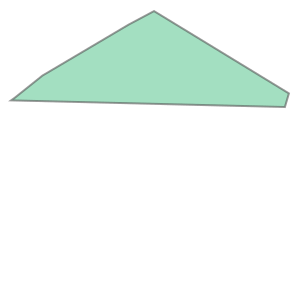

In [69]:
fan_polygon

In [68]:
polygon_points = [[xi, yi] for (xi, yi) in zip(intersection_line.xy[0], intersection_line.xy[1])] 
if first_point.distance(bottom_fan_edge) < last_point.distance(bottom_fan_edge):
    # keep line order
    polygon_points.extend([[mouth_point.x - normal_x * river_mouth_width / 2, mouth_point.y - normal_y * river_mouth_width / 2], 
                           [mouth_point.x + normal_x * river_mouth_width / 2, mouth_point.y + normal_y * river_mouth_width / 2]])
else:
    # reverse fan order
    polygon_points.extend([[mouth_point.x + normal_x * river_mouth_width / 2, mouth_point.y + normal_y * river_mouth_width / 2], 
                           [mouth_point.x - normal_x * river_mouth_width / 2, mouth_point.y - normal_y * river_mouth_width / 2]])
fan_polygon = shapely.geometry.Polygon(polygon_points)

In [48]:
shapely.geometry.Point([x[-1], y[-1]]).distance(shapely.geometry.LineString([[mouth_point.x + normal_x * river_mouth_width / 2, mouth_point.y + normal_y * river_mouth_width / 2],
                                                                             [fan_end_point.x + normal_x * end_width / 2, fan_end_point.y + normal_y * end_width / 2]]))
shapely.geometry.Point([x[0], y[0]]).distance(shapely.geometry.LineString([[mouth_point.x + normal_x * river_mouth_width / 2, mouth_point.y + normal_y * river_mouth_width / 2],
                                                                             [fan_end_point.x + normal_x * end_width / 2, fan_end_point.y + normal_y * end_width / 2]]))

444.05639667075644

In [ ]:
distance = numpy.inf
end_point = shapely.geometry.LineString()

for i, row in ocean_contours.iterrows():
    if row.geometry.intersects(extended_line):
        intersection_point = row.geometry.intersection(extended_line)
        if intersection_point.distance(mouth_point) < distance:
            distance = intersection_point.distance(mouth_point)
            end_point = intersection_point
            nearest_index = i

### Fan polygon
Define a fan polygon with initial width of the mouth width measurements increasing in width by x degree on each side. 

In [169]:
fan_angle = 15
end_width = river_mouth_width + 2 * distance * numpy.tan(numpy.pi/180 * fan_angle)

In [156]:
fan_line = shapely.geometry.LineString([mouth_point, end_point])

In [165]:
# Calculate line slope
length = numpy.sqrt((end_point.x - mouth_point.x) ** 2 + (end_point.y - mouth_point.y) ** 2)
dx = (end_point.x - mouth_point.x) / length
dy = (end_point.y - mouth_point.y) / length
        
# Calculate line normal
normal_x = -dy
normal_y = dx

In [176]:
fan_polygon = shapely.geometry.Polygon([[mouth_point.x - normal_x * river_mouth_width / 2, mouth_point.y - normal_y * river_mouth_width / 2], 
                                        [mouth_point.x + normal_x * river_mouth_width / 2, mouth_point.y + normal_y * river_mouth_width / 2],
                                        [end_point.x + normal_x * end_width / 2, end_point.y + normal_y * end_width / 2],
                                        [end_point.x - normal_x * end_width / 2, end_point.y - normal_y * end_width / 2]])

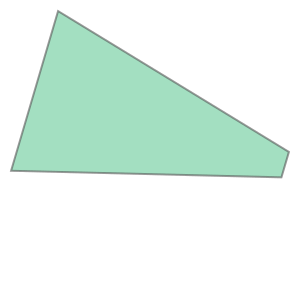

In [199]:
fan_polygon

### Fan depths
Define the depths within the centre of the fan

In [189]:
fan_depths = {'geometry': [], 'depths': []}

spacing = 10
number_of_samples = int(distance / spacing)
depth_increment = (-1 * end_depth - river_mouth_depth) / number_of_samples

for i in range(1, number_of_samples):
    fan_depths['geometry'].append(shapely.geometry.Point([mouth_point.x + dx * i * spacing, mouth_point.y + dy * i * spacing]))
    fan_depths['depths'].append(river_mouth_depth + i * depth_increment)

In [191]:
fan_depths = geopandas.GeoDataFrame(fan_depths, crs=2193)

<AxesSubplot:>

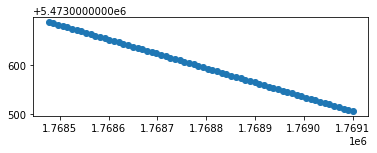

In [192]:
fan_depths.plot()